### 1. Get data

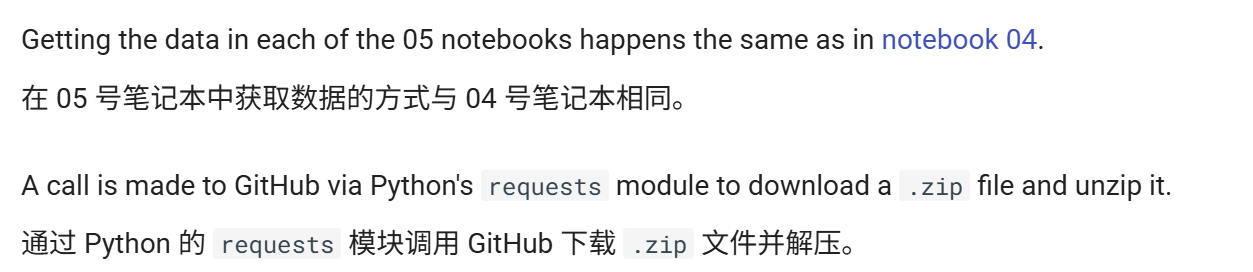

In [1]:
import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza steak sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...") 
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### 2. Create Datasets and DataLoaders (data_setup.py)
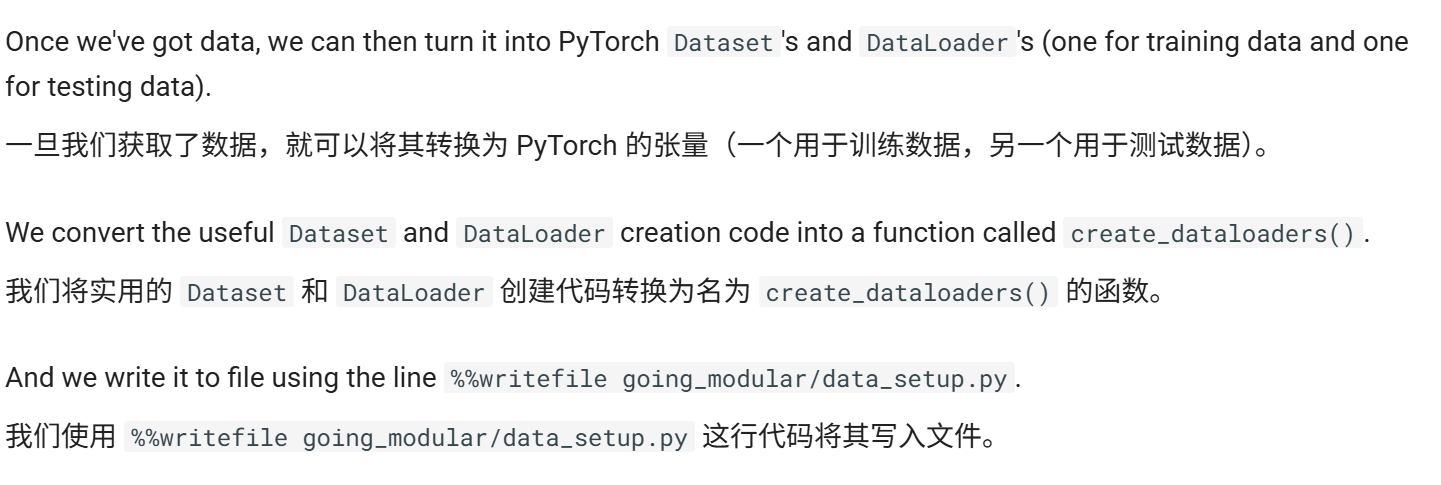

In [2]:
%%writefile going_modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
    """Creates training and testing DataLoaders.

    Takes in a training directory and testing directory path and turns
    them into PyTorch Datasets and then into PyTorch DataLoaders.

    Args:
        train_dir: Path to training directory.
        test_dir: Path to testing directory.
        transform: torchvision transforms to perform on training and testing data.
        batch_size: Number of samples per batch in each of the DataLoaders.
        num_workers: An integer for number of workers per DataLoader.

    Returns:
        A tuple of (train_dataloader, test_dataloader, class_names).
        Where class_names is a list of the target classes.
        Example usage:
        train_dataloader, test_dataloader, class_names = create_dataloaders(
            train_dir=path/to/train_dir,
            test_dir=path/to/test_dir,
            transform=some_transform,
            batch_size=32,
            num_workers=4)
    """
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False, # don't need to shuffle test data
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

Writing going_modular/data_setup.py


If we'd like to make `DataLoader`'s we can now use the function within `data_setup` like so:

```python
# Import data_setup.py
from going_modular import data_setup

# Create train/test dataloader and get class names as a list
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(...)
```

### 3. Making a model

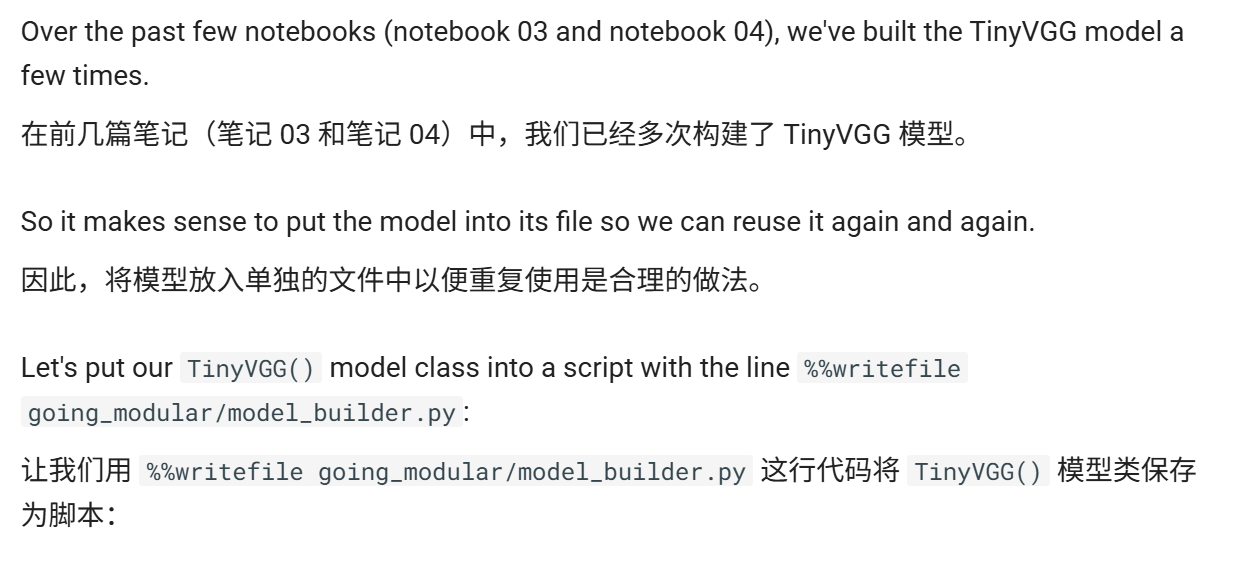

In [3]:
%%writefile going_modular/model_builder.py
'''
Contains PyTorch model code to instantiate a TinyVGG model.
'''
import torch
from torch import nn

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.

    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/

    Args:
        input_shape: An integer indicating number of input channels.
        hidden_units: An integer indicating number of hidden units between layers.
        output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2)

        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
    def forward(self, x:torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

Overwriting going_modular/model_builder.py


Now instead of coding the TinyVGG model from scratch every time, we can import it using:
```python
import torch
# Import model_builder.py
from going_modular import model_builder
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model from the "model_builder.py" script
torch.manual_seed(42)
model = model_builder.TinyVGG(input_shape=3,
                              hidden_units=10, 
                              output_shape=len(class_names)).to(device)
```

### 4. Creating `train_step()` and `test_step()` functions and `train()` to combine them


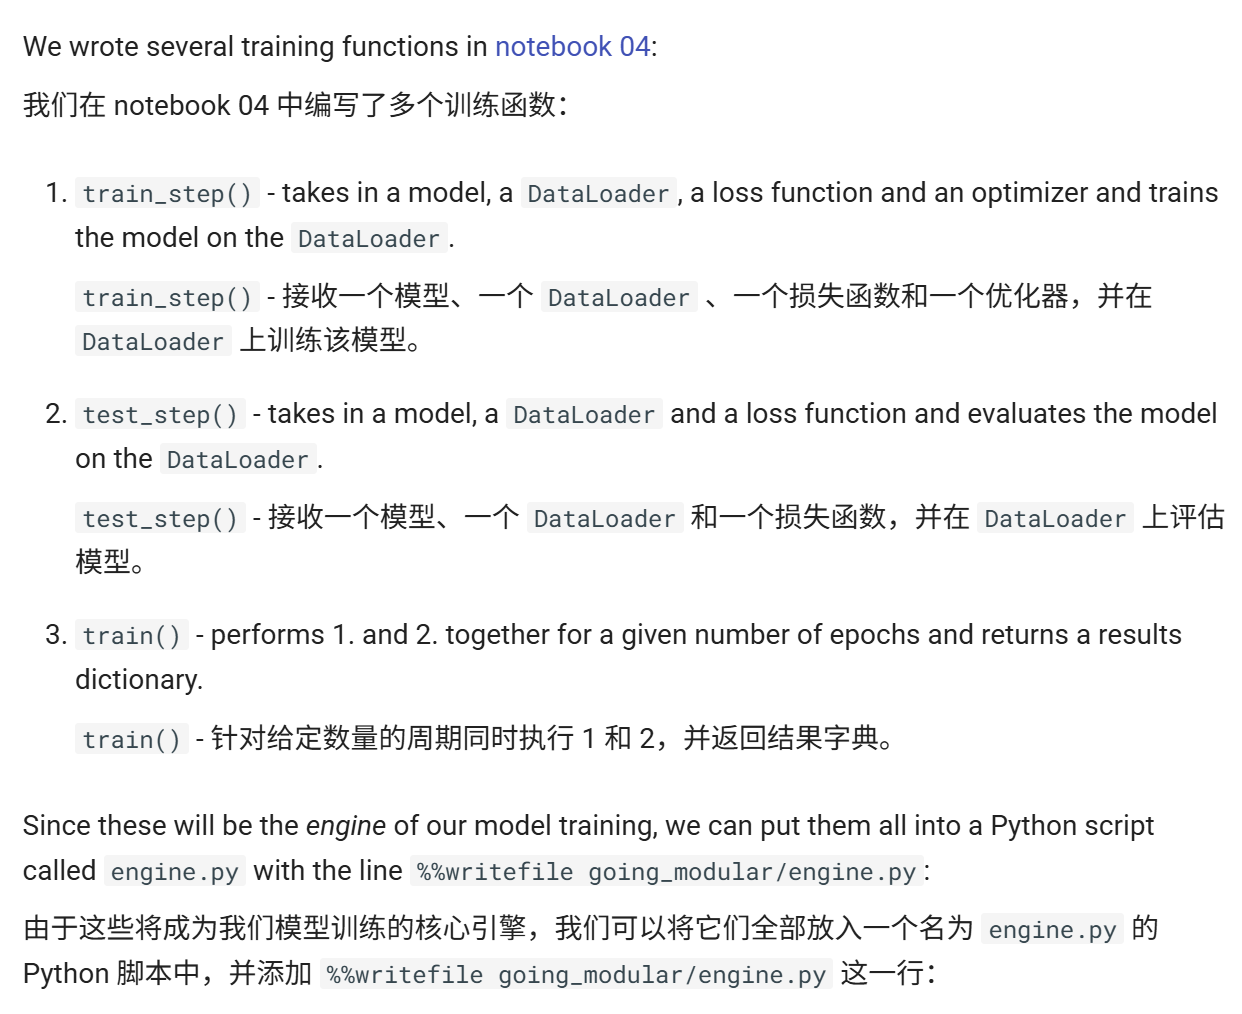

In [4]:
%%writefile going_modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
        model: A PyTorch model to be trained.
        dataloader: A DataLoader instance for the model to be trained on.
        loss_fn: A PyTorch loss function to minimize.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
        A tuple of training loss and training accuracy metrics.
        In the form (train_loss, train_accuracy). For example:

        (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
        model: A PyTorch model to be tested.
        dataloader: A DataLoader instance for the model to be tested on.
        loss_fn: A PyTorch loss function to calculate loss on the test data.
        device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
        A tuple of testing loss and testing accuracy metrics.
        In the form (test_loss, test_accuracy). For example:

        (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for.
        device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
        A dictionary of training and testing loss as well as training and
        testing accuracy metrics. Each metric has a value in a list for 
        each epoch.
        In the form: {train_loss: [...],
                    train_acc: [...],
                    test_loss: [...],
                    test_acc: [...]} 
        For example if training for epochs=2: 
                    {train_loss: [2.0616, 1.0537],
                    train_acc: [0.3945, 0.3945],
                    test_loss: [1.2641, 1.5706],
                    test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Writing going_modular/engine.py


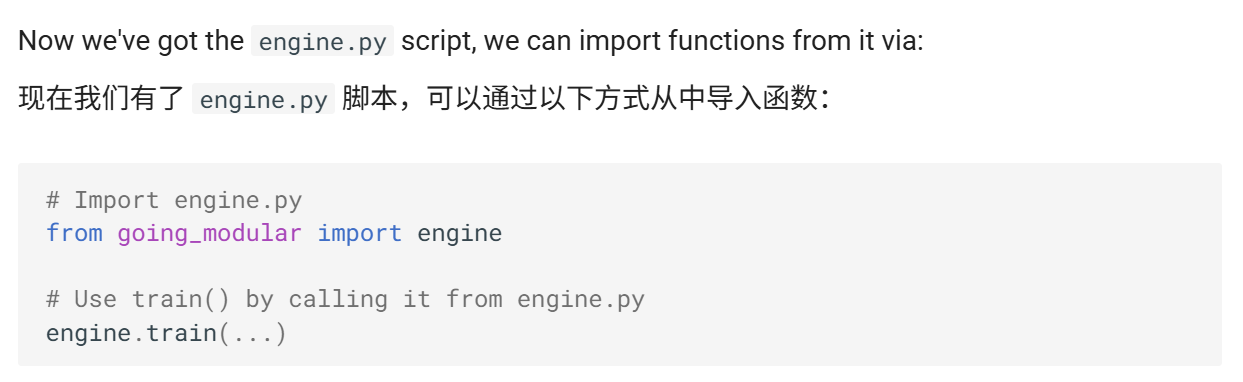

### 5. Creating a function to save the model (`utils.py`)

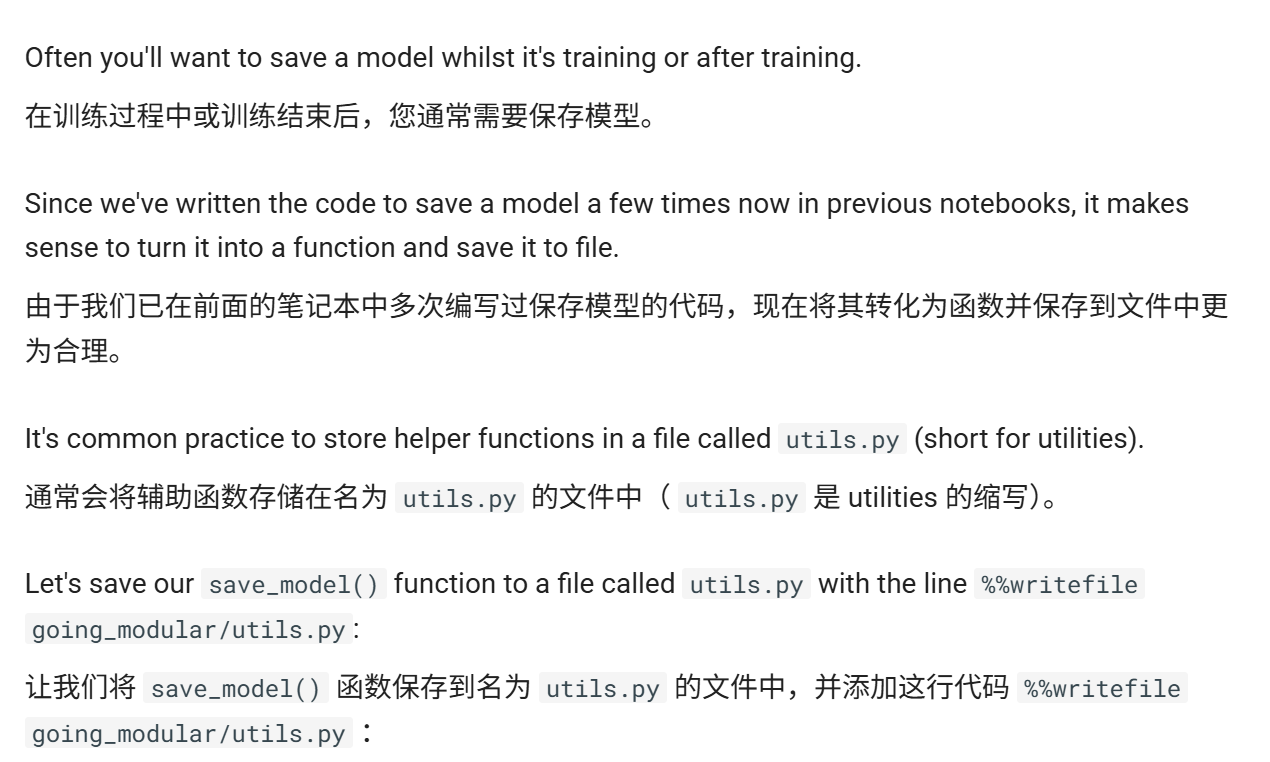

In [5]:
%%writefile going_modular/utils.py
'''
Contains various utility functions for PyTorch model training and saving.
'''
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
        model: A target PyTorch model to save.
        target_dir: A directory for saving the model to.
        model_name: A filename for the saved model. Should include
        either ".pth" or ".pt" as the file extension.

    Example usage:
        save_model(model=model_0,
                target_dir="models",
                model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                            exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
                f=model_save_path)

Writing going_modular/utils.py


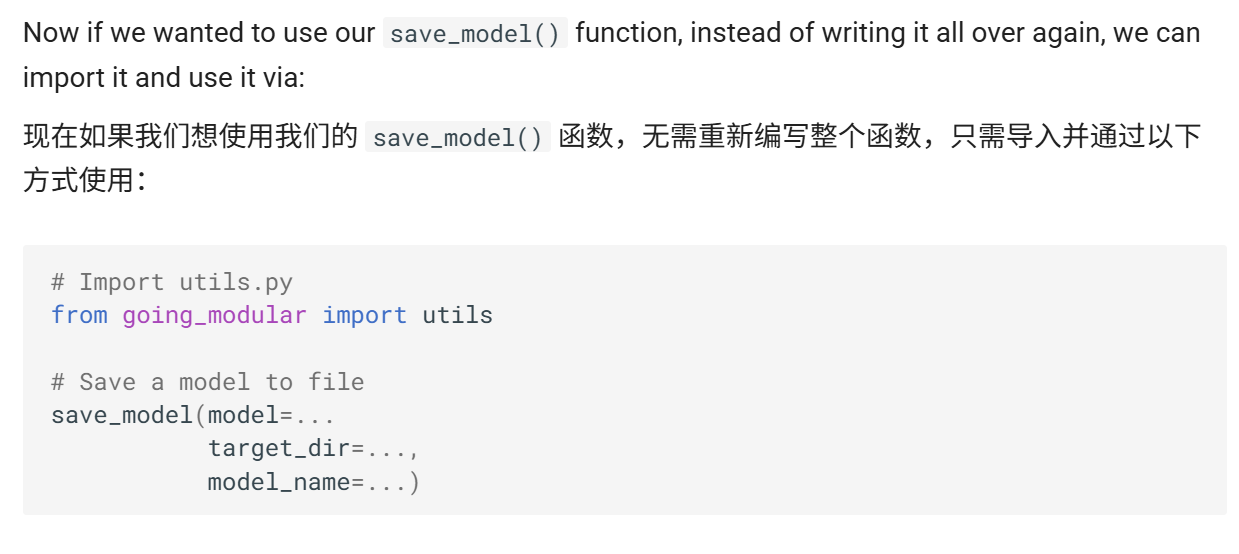

### 6. Train, evaluate and save the model (`train.py`)

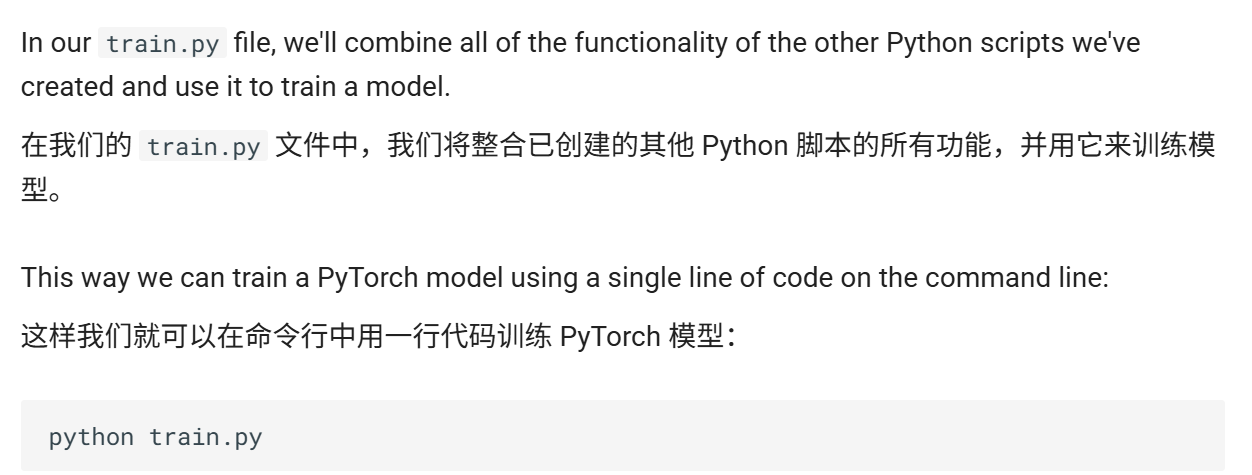

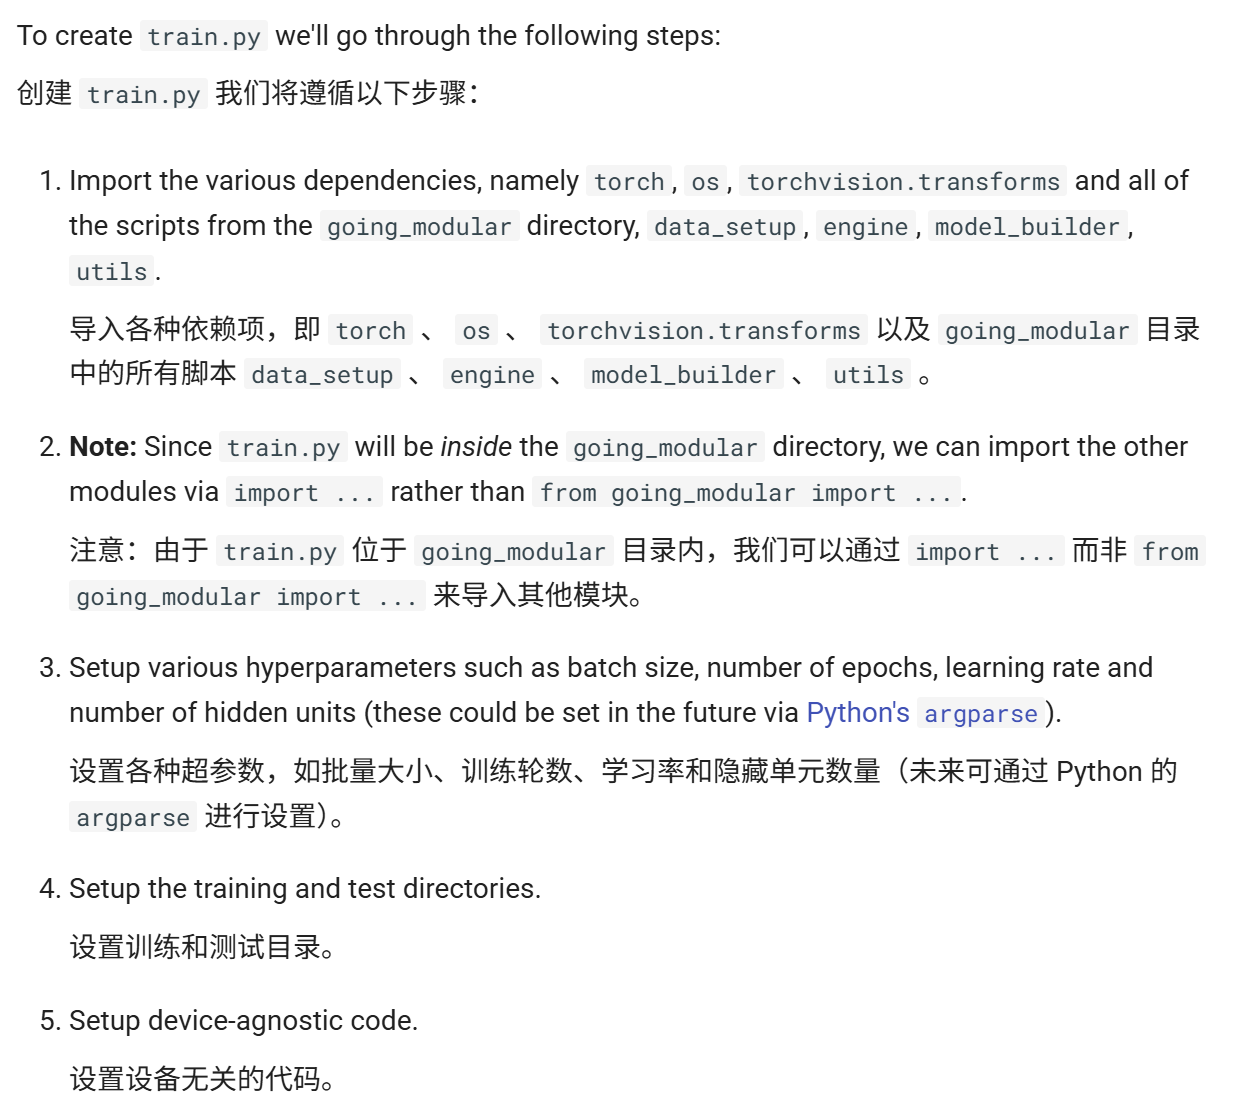

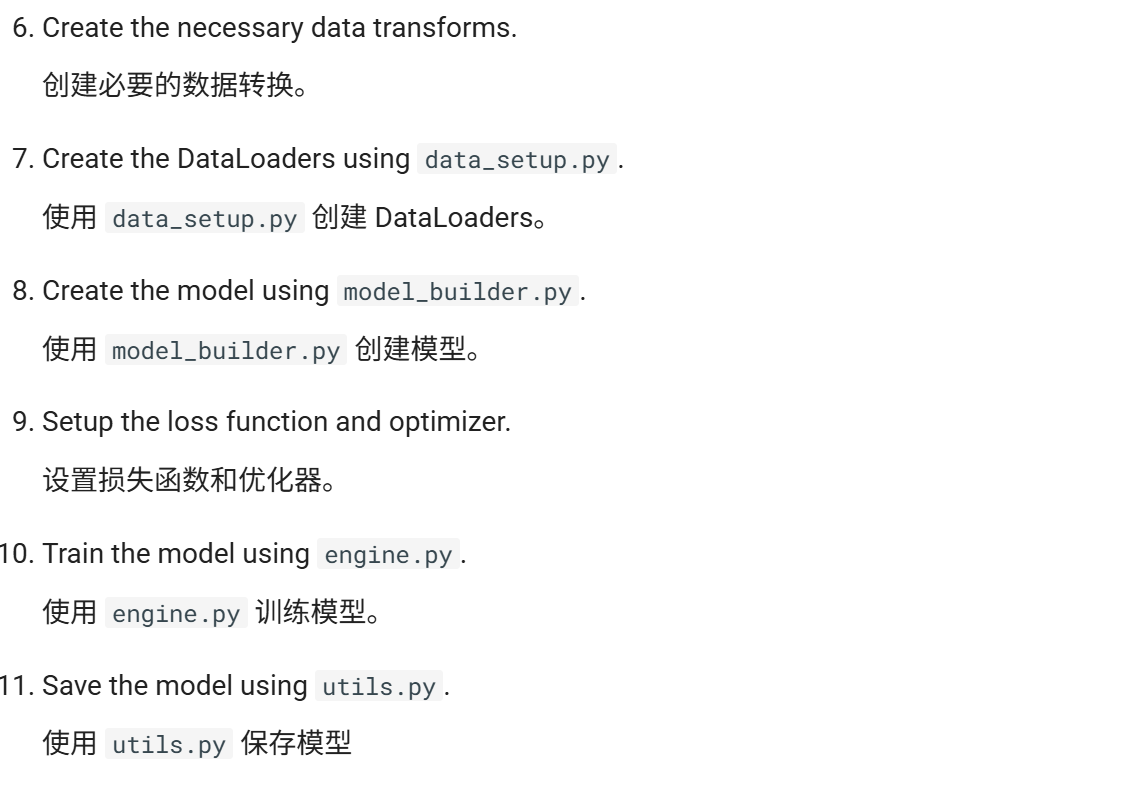

In [11]:
%%writefile going_modular/train.py
import os
from pathlib import Path
import torch
import data_setup, engine, model_builder, utils

from torchvision import transforms

# Setup hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# 当前文件 train.py 所在的目录: .../going_modular
THIS_DIR = Path(__file__).resolve().parent
PROJECT_ROOT = THIS_DIR.parent            # 回到上一级: .../05_PyTorch_Going_Modular
DATA_DIR = PROJECT_ROOT / "data"          # .../05_PyTorch_Going_Modular/data

# Setup directories
train_dir = DATA_DIR / "pizza_steak_sushi" / "train"
test_dir  = DATA_DIR / "pizza_steak_sushi" / "test"

# Setup directories
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Create DataLoader with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with help from model_builder.py
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_going_modular_script_mode_tinyvgg_model.pth")

Overwriting going_modular/train.py
